In [0]:
import math
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_d|ataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline

In [155]:
pip install tensorflow==1.15.0

In [0]:
from google.colab import files
df = pd.read_csv('coronaTrain.csv')

In [250]:
df

,0,0.1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,status
0,0,5280.167730,3837.700942,1681.942638,5843.046523,-232.842418,818.394788,3030.753422,2277.569997,573.577558,282.680870,3321.134300,1353.700022,-463.930981,1935.704376,748.599959,304.617765,-419.333218,296.916574,538.329173,496.466204,884.931764,794.804330,-71.818554,482.396261,493.740812,48.222171,469.980104,747.407534,-459.764341,1052.992014,315.694611,-621.680898,-66.706129,464.377154,-474.631642,336.774868,-184.841794,657.069201,600.903387,...,23.282259,9.961912,-62.397304,42.600331,-11.183636,-1.456689,29.526128,-25.378556,-48.384784,-8.593228,-23.947916,-27.980663,-22.854058,12.688071,-8.976869,20.168915,48.431260,0.716454,-26.934215,27.401115,38.747600,26.497335,-28.319580,40.165970,-35.771549,4.290065,52.935713,-44.104535,29.910581,-78.636803,-11.788928,-4.290970,2.594959,-43.219612,-4.240717,31.517564,-41.453802,17.277788,-20.736469,0
1,1,-3223.055169,-1115.166494,-1336.564180,1286.738497,3403.835973,1036.306212,-401.889306,323.775792,1494.498731,-294.079163,1006.501230,-992.933183,639.284349,163.265849,980.574076,-78.261892,-437.099861,-712.882036,1235.845296,138.133991,-113.468846,-440.383976,-439.403469,-416.380045,365.970890,154.659911,-176.980291,154.298142,122.132471,269.234719,-224.326848,-8.734305,429.215522,-626.857468,378.936418,-239.664122,-378.272973,185.449717,-41.904965,...,53.428987,-46.714345,10.834861,-30.750434,-148.940444,49.198456,21.705924,-32.069881,18.724506,-26.759843,-42.069763,-83.573455,-11.063993,117.414210,69.222109,27.126214,37.884661,-8.933438,-7.092926,37.554396,-6.988394,23.942378,-53.841705,-67.347380,-27.900833,-27.968235,35.853466,-26.972303,-31.792916,-93.890373,-86.010820,-31.261799,103.364060,46.960054,-62.536342,-92.178920,-39.621644,-7.973821,-30.334445,1
2,2,8007.313938,5491.331210,3663.342202,593.011444,-2989.930294,-1650.875980,1118.997993,2391.424050,2575.013614,30.669097,2960.726621,-337.153983,506.048412,270.057271,111.079143,790.828227,163.073575,208.558772,471.074753,-19.641849,-280.850623,219.615351,1394.863279,-308.617727,-277.958735,-1268.082064,811.021514,-941.306022,-268.634888,211.432653,294.717834,-188.059043,34.993698,388.937785,-700.768277,-835.995802,-325.857463,29.509863,65.063123,...,-54.022741,-50.189113,30.475534,-5.496953,-56.506716,24.873522,-29.698599,69.043162,-13.156570,64.776393,-84.248629,-68.555749,-93.178069,-13.350799,14.275225,49.948511,9.344961,30.682979,-26.317746,-41.999464,1.336059,-0.324023,-32.846916,-55.201533,19.014501,91.350159,11.790406,-63.717469,94.004348,29.118426,20.228240,-22.978302,-68.078558,-10.060078,-19.974270,43.649501,-40.868866,-88.093409,7.586640,0
3,3,4533.969789,1859.902341,-2106.670412,-2938.184416,-1435.850576,-1167.242348,-476.518632,-215.481546,-1838.518402,-308.499743,-267.731510,104.380561,2415.581685,-127.260849,985.299600,261.218087,70.203361,229.449880,704.191654,-1672.600795,787.467278,-706.969084,-27.932596,955.307530,-271.155783,-810.559933,455.439841,210.606068,-640.634160,613.661658,398.496972,44.938624,-665.352209,268.378651,-490.619712,448.335523,666.662537,699.258447,-364.994129,...,54.439894,-89.299496,-115.263327,62.767471,-14.397542,-61.092353,-82.999126,-64.772673,-96.208704,-19.375123,29.014326,-58.848985,75.296331,-22.359727,-4.172651,-56.348470,16.505295,34.216725,58.231320,10.486133,14.975363,38.274623,-67.015483,-47.072594,1.373115,-33.041945,14.303052,-35.189077,29.964567,-71.928587,-0.340331,-47.293885,-7.099134,-1.138214,-2.997165,20.675353,5.936402,80.723711,-58.106523,1
4,4,921.522640,-1200.312956,-14.678130,1779.298398,-3506.129638,855.198666,-943.207950,-1956.808320,320.996880,-1464.290576,549.846553,-293.719664,152.649830,1096.992308,-1480.191655,298.255723,-970.916478,-846.797954,-1328.268794,-154.230063,-341.5

In [251]:
df.isnull().sum()

0         0
0.1       0
1         0
2         0
3         0
         ..
996       0
997       0
998       0
999       0
status    0
Length: 1002, dtype: int64

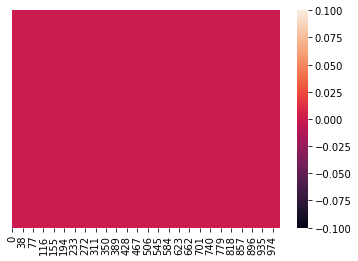

In [252]:
sns.heatmap(df.isnull(),yticklabels=False)

In [253]:
X=df.to_numpy()
print(X.shape)

(1287, 1002)


In [0]:
Y=X[:,-1]

In [0]:
X=np.delete(X,1001,axis=1)

In [256]:
print(X.shape)

(1287, 1001)


In [257]:
X[:,-1]

array([-20.73646889, -30.33444526,   7.58664043, ...,  38.33954635,
       -76.96893758, -30.46340378])

In [258]:
Y.shape

(1287,)

In [259]:
Y.reshape(1287,1)

array([[0.],
       [1.],
       [0.],
       ...,
       [2.],
       [1.],
       [1.]])

In [0]:
x_train=X #no dev or training set as there is need of more data for training to remove overfitting

In [0]:
y_train=Y

In [264]:
x_train.shape

(1287, 1001)

In [0]:
x_train=x_train.T
y_train=y_train.T

In [266]:
x_train.shape

(1001, 1287)

In [0]:
X_train = x_train/255.
X_test = y_train/255.

In [0]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    

    C = tf.constant(C,name="C")
    one_hot_matrix = tf.one_hot(indices=labels,depth=C,axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot

In [0]:
Y_train=one_hot_matrix(y_train,3)

In [0]:

def create_placeholders(n_x, n_y):
    
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_y -- scalar, number of classes (from 0 to 2, so -> 3)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"

    X = tf.placeholder(tf.float32,shape=(n_x,None),name="x")
    Y = tf.placeholder(tf.float32,shape=(n_y,None),name="y")
    
    return X, Y

In [0]:


def initialize_parameters():
    """
    
                        W1 : [25, 1001]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [3, 12]
                        b3 : [3, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   
    W1 = tf.get_variable("W1",[25,1001],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2",[12,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2",[12,1],initializer=tf.zeros_initializer())
    W3 = tf.get_variable("W3",[3,12],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3",[3,1],initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [275]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    

W1 = <tf.Variable 'W1:0' shape=(25, 1001) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                             # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1) 
    #D1 = np.random.rand(A1.shape[0], A1.shape[1])
    #D1 = D1 < 0.5 
    #A1 = np.multiply(A1, D1)
    #A1 /= 0.5   
    #A1 = tf.nn.dropout(A1,rate=0.1)                                          # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                             # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2) 
    #A2 = tf.nn.dropout(A2,rate=0.1)
    #D2 = np.random.rand(A2.shape[0], A2.shape[1])
    #D2 = D2 < 0.8  
    #A2 = np.multiply(A2, D2) 
    #A2 /= 0.8                                            # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                              # Z3 = np.dot(W3, A2) + b3
    ### END CODE HERE ###
    
    return Z3

In [201]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(1001, 3)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(3, ?), dtype=float32)


In [0]:
def compute_cost(Z3, Y, parameters):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    #regularizer = tf.nn.l2_loss(parameters["W3"])
    #cost = tf.reduce_mean(cost + 0.01 * regularizer)
    
    return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [0]:

def model(X_train, Y_train, learning_rate = 0.0001,
          num_epochs = 900, minibatch_size = 128, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x,n_y)

    parameters = initialize_parameters()   
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y, parameters)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})  
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))

        
        return parameters

Cost after epoch 0: 0.214280
Cost after epoch 100: 0.021497
Cost after epoch 200: 0.002218
Cost after epoch 300: 0.000498
Cost after epoch 400: 0.000162
Cost after epoch 500: 0.000065
Cost after epoch 600: 0.000033
Cost after epoch 700: 0.000014
Cost after epoch 800: 0.000007


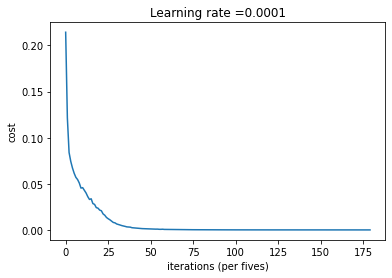

Parameters have been trained!
Train Accuracy: 1.0


In [277]:
parameters = model(X_train, Y_train)

In [278]:
parameters

{'W1': array([[ 0.10430135, -0.09761207, -0.15630536, ...,  0.05558628,
         -0.05101742,  0.09166704],
        [-0.0268817 , -0.02167721,  0.0604618 , ...,  0.04113201,
          0.08584778,  0.00018822],
        [-0.04074611, -0.08064841, -0.03603315, ..., -0.02391583,
         -0.06880244,  0.03616347],
        ...,
        [ 0.00993806,  0.00236568,  0.01700058, ..., -0.02778785,
         -0.08302251,  0.06080605],
        [ 0.08279942, -0.08792328,  0.05272565, ...,  0.08584731,
          0.05575366,  0.05100022],
        [-0.00226401,  0.08617144, -0.00675209, ..., -0.02101662,
         -0.06713514,  0.03338556]], dtype=float32),
 'W2': array([[-0.3378916 , -0.42221588, -0.29698333, -0.1467116 ,  0.13569345,
          0.223993  ,  0.3720455 , -0.09351382, -0.02531506, -0.04394333,
         -0.17261732, -0.08117843,  0.34848073,  0.25048807,  0.23934597,
          0.3668681 ,  0.09280814, -0.0718897 , -0.11084514, -0.20267531,
          0.39187285, -0.24773693, -0.01961858,  0

In [0]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [1001, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           
    Z1 = tf.add(tf.matmul(W1, X), b1)                      
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     
    
    return Z3

In [0]:
df = pd.read_csv('coronaTest.csv')

In [283]:
df


,Index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0,2360.468121,3170.244556,1697.758472,5598.597705,-1122.907590,980.658815,1178.046905,3296.901426,549.362795,49.595597,183.509266,1211.977477,1262.502753,1368.788956,-2276.543059,-1335.090753,-212.659272,532.109807,-810.548280,588.758202,-340.212482,1439.748692,-426.866895,-1469.882024,-564.558075,-1209.874821,52.821282,330.617149,-518.156424,584.181509,-1291.105177,-443.155899,-360.604636,-2.107810,215.012485,89.024506,510.410751,627.101118,-10.516841,...,29.148603,-8.599300,66.539840,-8.283419,-42.816060,-27.340752,47.810150,3.591673,84.913495,16.481012,-19.598545,18.228992,-12.402021,1.174884,-35.989435,-82.473293,-38.990838,-15.538851,8.744233,27.246030,-9.390100,15.106517,20.590284,40.739774,35.332582,-22.306783,-57.852363,-0.955010,35.901604,-3.441972,31.733982,18.159848,62.793697,26.542204,20.632675,11.898688,24.426936,12.326023,2.524550,23.820559
1,1,9824.143037,3357.881942,201.543848,3019.119601,-4953.704512,-666.601915,192.440353,4142.487313,2262.905200,3473.093884,3428.872191,-959.646908,1346.007076,-851.257500,-1686.009707,-351.386485,-1131.527668,-645.698849,519.428115,-101.024412,608.118924,485.469835,1011.112649,-218.449299,-79.665028,-287.986496,1147.248000,-514.139719,137.642218,-198.225318,459.843928,182.255016,-100.992928,-665.059386,-610.858137,-1177.861452,-155.644804,-1158.856726,180.743190,...,46.696013,-17.002781,-72.811807,27.001469,-33.044543,-96.823669,39.170930,-57.267981,-21.497919,-2.753119,35.805266,-22.718090,108.345193,4.579413,-18.938062,100.281744,92.604424,14.138264,-30.021725,-117.295595,-34.570546,-53.121473,1.999935,5.393877,-26.335882,-60.667144,16.370454,83.073467,44.789103,69.728169,6.011481,46.987701,-23.835829,14.808673,5.638663,-16.839797,20.230744,-1.293179,82.583835,59.123195
2,2,2341.483987,1972.182132,5321.074820,2076.880657,-1057.674537,550.924115,2006.304348,-920.764523,-639.762922,1050.404691,-41.603686,726.397563,-738.329661,1413.162003,-917.572958,664.327245,-234.629142,-341.365622,261.294974,1082.605419,-986.437085,91.498188,-123.832360,152.235013,1001.223934,286.791099,-279.958295,-158.824195,-492.209953,560.838549,353.549126,-931.611769,80.180565,614.302278,358.629642,23.290468,-424.597720,431.006875,340.104218,...,38.479030,23.321131,-8.784649,5.246270,-40.132611,1.123394,2.276791,-43.241372,-16.222583,-1.821116,-17.519430,-75.939261,-21.738916,39.099933,-27.455858,21.515199,23.609658,-62.233125,-44.365526,-34.105924,16.988029,-15.501307,-4.706596,-9.810633,-43.316677,-37.357157,22.025680,-32.602385,-39.093888,-3.860631,29.900149,-16.289829,-31.641735,-11.114851,-2.929377,-58.487379,6.710407,1.146231,24.553120,-35.122233
3,3,9588.800823,10121.225552,7233.253861,-495.263472,-1506.855675,2146.521265,-2909.550994,878.050546,2200.871095,-1471.991097,3075.817676,2813.430536,3373.124463,1066.085783,2793.477377,629.586314,1371.752610,1845.284692,-2145.671494,1527.196015,1583.928947,4674.812584,733.595596,3273.388530,-757.725887,635.803051,-1069.194463,1840.271386,3638.883815,1686.720092,1956.793573,652.880342,-485.311419,-331.213234,162.956589,-1224.337104,340.360857,-671.440356,3.144758,...,42.536026,-43.919876,32.039115,30.704323,-18.410216,-13.252597,-22.474836,37.962882,-20.336104,-13.097876,-7.991223,-15.281986,-40.714042,34.790929,1.112802,15.620396,-4.137257,-20.670453,6.582335,20.951638,20.756619,29.675617,32.265475,-12.947977,-41.637235,11.811077,-13.633315,-18.336532,50.602620,-24.139677,18.709080,8.423986,5.825512,-41.753367,-16.802495,-25.847536,-25.330617,13.822268,10.729671,-5.975498
4,4,2902.667817,2847.755305,3424.176309,5046.393309,-1387.708023,-1713.565415,3364.930083,-253.248893,-3011.743840,3458.805993,2123.225694,1170.464589,1290.625117,566.410344,-861.537708,-421.908097,-915.13695

In [0]:
X=df.to_numpy()

In [285]:
X.shape

(1332, 1001)

In [0]:
X=X.T

In [287]:
X.shape

(1001, 1332)

In [0]:
predictions=[]

In [289]:
for i in range(1332):
  prediction=predict(X[:,i].reshape(1001,1),parameters)
  predictions.append(prediction)
  print(prediction)

[0]
[0]
[2]
[0]
[0]
[2]
[2]
[2]
[2]
[0]
[0]
[0]
[1]
[1]
[1]
[2]
[0]
[1]
[1]
[2]
[2]
[1]
[2]
[1]
[2]
[2]
[2]
[0]
[1]
[2]
[2]
[0]
[0]
[1]
[2]
[2]
[2]
[0]
[1]
[2]
[0]
[1]
[0]
[2]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[2]
[2]
[2]
[1]
[0]
[1]
[2]
[1]
[2]
[0]
[0]
[0]
[2]
[2]
[2]
[0]
[1]
[2]
[1]
[0]
[2]
[1]
[2]
[0]
[1]
[0]
[0]
[2]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[2]
[0]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[2]
[2]
[1]
[1]
[2]
[1]
[0]
[0]
[0]
[0]
[2]
[0]
[1]
[2]
[2]
[1]
[1]
[1]
[2]
[1]
[2]
[1]
[1]
[1]
[2]
[0]
[2]
[1]
[2]
[1]
[0]
[0]
[1]
[1]
[2]
[0]
[1]
[0]
[2]
[0]
[1]
[2]
[2]
[2]
[0]
[2]
[2]
[1]
[2]
[2]
[1]
[1]
[1]
[2]
[1]
[0]
[0]
[0]
[1]
[0]
[2]
[2]
[2]
[2]
[1]
[2]
[1]
[1]
[0]
[0]
[1]
[0]
[2]
[2]
[0]
[2]
[2]
[0]
[1]
[1]
[2]
[2]
[2]
[2]
[2]
[1]
[2]
[0]
[2]
[0]
[2]
[2]
[2]
[2]
[1]
[1]
[0]
[0]
[2]
[1]
[1]
[1]
[2]
[2]
[1]
[2]
[2]
[1]
[2]
[2]
[0]
[1]
[2]
[1]
[2]
[0]
[1]
[0]
[1]
[0]
[2]
[0]
[1]
[0]
[1]
[2]
[0]
[1]
[1]
[1]
[1]
[1]
[2]
[1]
[2]
[1]
[0]
[0]
[1]
[0]
[0]
[2]
[0]
[1]
[1]
[2]
[1]
[1]
[2]


In [290]:
predictions

[array([0]),
 array([0]),
 array([2]),
 array([0]),
 array([0]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([2]),
 array([0]),
 array([1]),
 array([1]),
 array([2]),
 array([2]),
 array([1]),
 array([2]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([0]),
 array([1]),
 array([2]),
 array([2]),
 array([0]),
 array([0]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([0]),
 array([1]),
 array([2]),
 array([0]),
 array([1]),
 array([0]),
 array([2]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([2]),
 array([2]),
 array([2]),
 array([1]),
 array([0]),
 array([1]),
 array([2]),
 array([1]),
 array([2]),
 array([0]),
 array([0]),
 array([0]),
 array([2]),
 array([2]),
 array([2]),
 array([0]),
 array([1]),
 array([2]),
 array([1]),
 array([0]),
 array([2]),
 array([1]),
 array([2]),

In [292]:
len=0
for i in predictions:
  len=len+1
print(len)

1332


In [0]:
abc_predictions=[]
for i in predictions:
  abc_predictions.append(np.ndarray.item(i))

In [294]:
len=0
for i in abc_predictions:
  len=len+1
print(len)

1332


In [0]:
index=[]
for i in range(1333):
  index.append(i)

In [296]:
index

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [0]:
dict={"index":index,"status":abc_predictions}

In [0]:
len=0
for i in index:
  len=len+1

In [299]:
len

1333

In [300]:
index[0]

0

In [301]:
index.pop(0)

0

In [302]:
index[0]

1

In [0]:
df=pd.DataFrame(dict)

In [304]:
df

,index,status
0,1,0
1,2,0
2,3,2
3,4,0
4,5,0
...,...,...
1327,1328,0
1328,1329,0
1329,1330,0
1330,1331,1


In [305]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [306]:
df.to_csv('data12345678910.csv')
!cp data.csv "drive/My Drive/"

cp: cannot stat 'data.csv': No such file or directory
